Selected features: ['C' 'D' 'E' 'F']


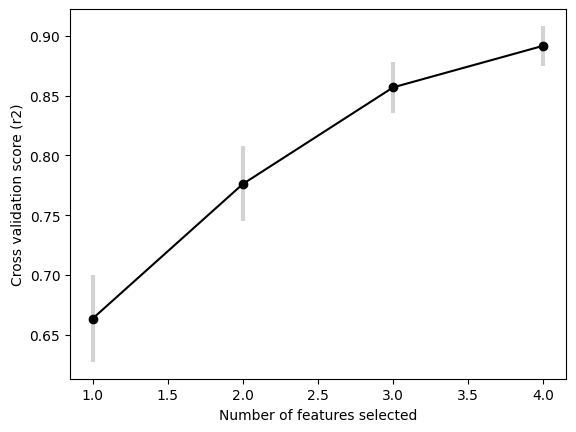

In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Generate a dummy dataset
X, y = make_regression(n_samples=1000, n_features=6,
                       noise=0.1, random_state=42)
df = pd.DataFrame(X, columns=['A', 'B', 'C', 'D', 'E', 'F'])
df['target'] = y

# Define the fixed features and the features to be eliminated
fixed_features = ['A', 'B']
elimination_features = ['C', 'D', 'E', 'F']

# Define a pipeline for the elimination features
elimination_pipeline = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('rfecv', RFECV(estimator=LinearRegression(), cv=5, scoring='r2'))
])

# Define a preprocessor that applies the elimination pipeline to the elimination features,
# and applies scaling to the fixed features
preprocessor = ColumnTransformer(transformers=[
    ('elim', elimination_pipeline, elimination_features),
    ('fix', StandardScaler(), fixed_features)
])

# Define the final pipeline that includes preprocessing and model training
pipeline = Pipeline(steps=[
    ('pre', preprocessor),
    ('reg', LinearRegression())
])

# Fit the pipeline to the all data
X_all = df[fixed_features + elimination_features]
y_all = df['target']

pipeline.fit(X_all, y_all)

# Access the selected features
selected_features_mask = pipeline.named_steps['pre'].transformers_[
    0][1].named_steps['rfecv'].support_
print(
    f'Selected features: {np.array(elimination_features)[selected_features_mask]}')

# Plot the R^2 score as a function of the number of selected features
num_features = range(1, len(pipeline.named_steps['pre'].transformers_[
                     0][1].named_steps['rfecv'].cv_results_['mean_test_score']) + 1)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (r2)")
plt.errorbar(num_features,
             pipeline.named_steps['pre'].transformers_[
                 0][1].named_steps['rfecv'].cv_results_['mean_test_score'],
             yerr=pipeline.named_steps['pre'].transformers_[
                 0][1].named_steps['rfecv'].cv_results_['std_test_score'],
             fmt='o-', color='black', ecolor='lightgray', elinewidth=3, capsize=0)
plt.show()